In [32]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from random import randint
from shared.autoencoderHelpers import read_n_images, generate_img_from_folder, get_input_shape, get_num_examples, plot_history, get_images, bgr2rgb, plot_reconstruction
import pickle,glob, cv2

In [2]:
in_shape = (200,200,3)



input_img = Input(shape=in_shape, name='input_layer')

x = Conv2D(16, (3, 3), activation='relu', padding='same', name='enc_conv1')(input_img)
x = MaxPooling2D((2, 2), padding='same', name='enc_max_pool1')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='enc_conv2')(x)
x = MaxPooling2D((2, 2), padding='same', name='enc_max_pool2')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='enc_conv3')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='enc_max_pool3')(x)

# at this point the representation is (25, 25, 8) - see model summaries

x = Conv2D(8, (3, 3), activation='relu', padding='same', name='dec_conv1')(encoded)
x = UpSampling2D((2, 2), name='dec_up_samp1')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', name='dec_conv2')(x)
x = UpSampling2D((2, 2), name='dec_up_samp2')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same', name='dec_conv3')(x)
x = UpSampling2D((2, 2), name='dec_up_samp3')(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='output_layer')(x)

# Generate models
segmenter = Model(input_img, decoded)



Instructions for updating:
Colocations handled automatically by placer.


segmenter.summary()

In [3]:
segmenter.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 200, 200, 3)       0         
_________________________________________________________________
enc_conv1 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
enc_max_pool1 (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
enc_conv2 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
enc_max_pool2 (MaxPooling2D) (None, 50, 50, 8)         0         
_________________________________________________________________
enc_conv3 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
enc_max_pool3 (MaxPooling2D) (None, 25, 25, 8)         0         
__________

In [6]:
segmenter.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mean_squared_error'])

In [45]:
def get_imagesPP(method, batchSize):
    locInput = "../data/segmentation/foregroundBackground/{}/images".format(method)
    locLabel = "../data/segmentation/foregroundBackground/{}/labels".format(method)
    while True:
            with open('../data/segmentation/foregroundBackground//labels.pickle', 'rb') as f:
                data = pickle.load(f)

            modes = list(data.keys())
            del modes[-1]

            assert method in modes, "'{}' not a valid mode (must be one of {})".format(method, str(modes))
            data = data[method]
            for idx in range(0, len(data), batchSize):
                start = idx
                end = idx + batchSize
                imagesInput = read_n_imagesPP(data, start, end, locInput)
                imagesLabel = read_n_imagesPP(data, start, end, locLabel)

                yield (imagesInput / 255, imagesLabel / 255)

In [25]:
def read_n_imagesPP(dataset, start, end, loc):
    """
    Read images (should be jpg) from a dataset (from indexes start to end).
    :param dataset: tuple - (image_name - no file extension, one_hot_label)
    :param start: int - start index
    :param end: int - end index
    :param loc: str - directory location of the images
    :return: numpy, numpy - numpy array of (BGR) images and numpy vector of labels (0 - label_1, 1 - label_2, ...)
    """
    assert glob.glob(loc), "Check directory."
    assert glob.glob("{}/*.jpg".format(loc)), "Check file extension (should be 'jpg')."
    images_list = dataset[start:end]
    images = [cv2.imread("{}/{}.jpg".format(loc, image)) for image in images_list]
    return np.array(images)

In [35]:
BATCH_SIZE_TRAIN = 10
NUM_SAMPLES_TRAIN = get_num_examples( "../data/segmentation/foregroundBackground/",'training')
STEPS_PER_EPOCH = ceil(NUM_SAMPLES_TRAIN/BATCH_SIZE_TRAIN)

BATCH_SIZE_VAL= 10
NUM_SAMPLES_VAL = get_num_examples( "../data/segmentation/foregroundBackground/", 'test')
VALIDATION_STEPS=ceil(NUM_SAMPLES_VAL/BATCH_SIZE_VAL)

EPOCHS = 5

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = segmenter.fit_generator(get_imagesPP('training', BATCH_SIZE_TRAIN), shuffle=True,
                                    validation_data=get_imagesPP('test', BATCH_SIZE_VAL),
                                    steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS,
                                    epochs=EPOCHS)

Epoch 1/5
90/90 [==============================] - 66s 733ms/step - loss: 6.3446 - mean_squared_error: 0.2203 - val_loss: 6.1836 - val_mean_squared_error: 0.2133
Epoch 2/5
90/90 [==============================] - 65s 726ms/step - loss: 6.2700 - mean_squared_error: 0.2171 - val_loss: 6.0922 - val_mean_squared_error: 0.2089
Epoch 3/5
90/90 [==============================] - 64s 708ms/step - loss: 6.2039 - mean_squared_error: 0.2143 - val_loss: 5.9296 - val_mean_squared_error: 0.2016
Epoch 4/5
90/90 [==============================] - 64s 706ms/step - loss: 6.0118 - mean_squared_error: 0.2060 - val_loss: 5.7078 - val_mean_squared_error: 0.1929
Epoch 5/5
90/90 [==============================] - 64s 712ms/step - loss: 5.8884 - mean_squared_error: 0.2008 - val_loss: 5.6025 - val_mean_squared_error: 0.1886


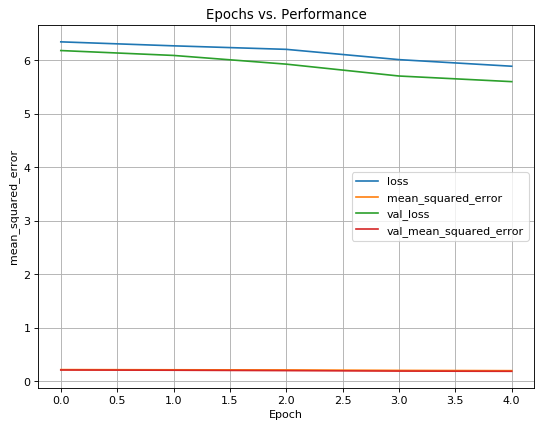

In [36]:
plot_history(history)

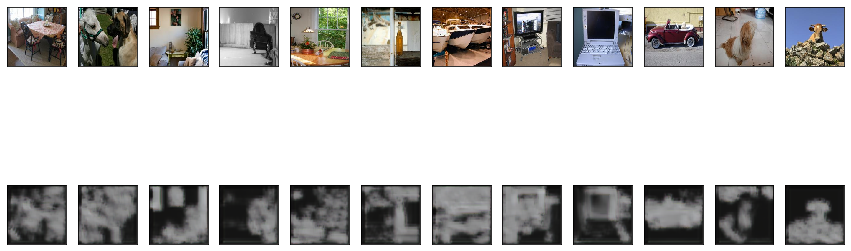

In [55]:
num_images = 5
idxs = [0,1,2,3,4,5,6,7,8,9,10,11]
def plot_reconstructionPP(decoded_imgs, data_dir, mode, idxs):
    num_images = len(idxs)
    original_images,_ = next(get_imagesPP(mode, 12))
    
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(idxs):
        # display original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(bgr2rgb(original_images[i]*255))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        decoded_to_plot = decoded_imgs[idx] * 255
        plt.imshow(bgr2rgb(decoded_to_plot))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
plot_reconstructionPP(decoded_imgs, "../data/segmentation/foregroundBackground/", 'test', idxs)

In [37]:
#Decoding images
BATCH_SIZE_TEST = 10
NUM_SAMPLES_TEST = get_num_examples( "../data/segmentation/foregroundBackground/",'training')
STEPS_TEST = ceil(NUM_SAMPLES_TEST/BATCH_SIZE_TEST)

decoded_imgs = segmenter.predict_generator(get_imagesPP('test', BATCH_SIZE_TEST),steps=STEPS_TEST)